# **Ensemble Methods and Random Forests**
---
## **Summary**
* **Ensemble methods**: **Wisdom of the crowd**: aggregating the predicitons of a group of predictors
* **Voting**: hard vs soft
* **Bagging** & **Pasting**: **boostrap aggregating** w/ and w/o replacement, respectively
* **Boosting**: **hypothsis boosting**, correcting the predecessor prodictors during sequential training 
* **Stacking**: **stacked generalization**, training the model to aggregation
* An ensemble of **Decision Trees** $\Longrightarrow$ **Random Forest**
* e.g., Netflix Prize Competition
* <img src="images/4_training_diverse_classifiers.png" width=500>

## **References**
1. Géron, A. 2017. Hands-Machine Learning with Scikit-Learn & TensorFlow. O'Reily Inc.             
2. Grus, J. 2019. Data Science from Scratch. O'Reily Inc.
3. Brenna, G. Random Forest, etc. slides. DS SEA 2020A.

## **Concept**
### **Voting Classifiers**
* **Majority vote** $\Longrightarrow$ **hard voting**: aggregating the predictions and predicting the class that gets the most votes.
    * working best when the predictors are indepdent from each other
    * using very different algorithms to imporve the ensemble's accuracy
    <img src="images/4_majority_voting.png" width=500>


* **Soft vote**: Predicting the class with the highest class probability and averaging over all the individual classifier
    * **only** if all classifiers have `predict_prob()`
    
### **Bagging and Pasting**
* **Bagging** and **Pasting**: training on subsets of dataset
* **Aggregation function**
    * statistical (e.g., voting) model for classification
    * averaging for regression
* **Subsets**: instances _vs_ features
    * **Random Patches**: instance + features (`boostrap=False` and `max_sample=1.0`)
    * **Random Subspace**: featrues only (`boostrap_features=True` and `max_features<1.0`)
* **Out-of-Bag** Evaluation (oob)
    * `scikit-learn` `BaggingClassifier`
        * 63% data were sampled on average for each predictor
        * 37% data never sampled by the predictors
        * set `oob_score=True`
        
### **Boosting**
#### **AdaBoost (Adaptive boosting)**
* Increasing the relative weight of misclassified training instances $\Longrightarrow$ sequentially training the model with updated weights, so on.           
* <img src="images/4_adaboosting.png" width=400>
* Algorithm:
    * **initially**, $w^{(i)} = \frac{1}{m}$, weighted error rate of the $j^{th}$ predictor      
      $r_{j} = \frac{\displaystyle\sum_{\substack{i=1 \\
                \hat{y}_{j}^{(i)}\neq{y^{(i)}}
                }}^{m}w^{(i)}}
                {\displaystyle\sum_{i=1}^{m}w^{(i)}}$
        , where $\hat{y}_{j}^{(i)}$ is the $j^{th}$ predictor's prediction fro the $i^{th}$ instance.
    * **predictor weight**:
      $\alpha_{j} = \eta log\frac{1-r_j}{r_j}$
        , the $\alpha\uparrow$, the more accurate the predictor is.
    * **boosting** the misclassified instances with updated weights\
      $\text{for i} = 1,2,..., m$\
      $w^{(i)}\leftarrow
                \begin{cases}
                w^{(i)}                 & \text{if }\hat{y}_{j}^{(i)} = y^{(i)} \\
                w^{(i)}exp\big(\alpha_{j}\big)  & \text{if }\hat{y}_{j}^{(i)}\neq{y^{(i)}}
                \end{cases}$\
        then all the instance weights are normalized (i.e., divided by $\sum_{i=1}^{m}w^{(i)}$).
    * **stopping** until the desired number of predictors is reached, or a perfect predictor is found
    * **prediction**: computing the predictors and weighs them using the predictor weights $\alpha_{j}$.\
      $\hat{y}(x) = argmax_c
               \displaystyle\sum_{\substack{j=1 \\
                           \hat{y}_{j}(x)= k
                           }}^{N}\alpha_{j}$
        , where $N$ is the number of predictors
    * `Scikit-Learn`: 
        * a multiclass version of AdaBoost called _SAMME_ (Stagwise Additive Modeling using a Multiclass Exponential loss function)
        * _SAMME.R_ (R stands for 'Real') for estimating probabilities (if `predict_prob` exists)

#### **Gradient Boosting**
* fitting the new predictor to the _residual errors_ of the preceding predictor
* **Gradient Tree Boosting** & **Gradient Boosted Regression Trees** (GBRT)
* <img src="images/4_gradient_boosting.png" width=500>
* **shrinkage**: `learning_rate` $\Longrightarrow$ not enough _vs_ too many
* **optimization**: `staged_predict()`
* **early stopping**: `warm_start=True` $\Longrightarrow$ allowing incremental training
* **XGBoost**: Extreme Gradient Boosting

### **Stacking**
* aggregating the predictions of all predictors
* training based on all predictions as inputs $\Longrightarrow$ _blender_ or _meta learner_

### **Random Forests**
* an ensemble of Decision Trees: bagging (generally) + pasting (sometimes)
* `RandomForestClassifier` +  `RandomForestRegressor`
* hyperparameters tunining: same as `DecisionTreeClassifier` + `BaggingClassifier`
* **Extremely Randomized Trees** (Extra-Trees)
    * Using random thresholds for each feature
    * Trade-off: more bias for a lower variance
    * Faster than tahn regular Random Forests
* feature importance
    * measuring how much the tree nodes reduce impurity (Gini) on average (across all trees in the forest)
* **handy to understand feature importance for performing feature selection**

## **Examples**
### **Voting Classifier**

In [3]:
import numpy as np
from sklearn.datasets import make_moons # using the moons datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
df_moons = make_moons(n_samples=1000, noise=0.30, random_state=45)
X = df_moons[0]
y = df_moons[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =45)

log_clf = LogisticRegression(solver='lbfgs', random_state=45)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=45)
svm_clf_hard = SVC(gamma='scale', random_state=45)
svm_clf_soft = SVC(gamma='scale', probability=True, random_state=45)

# Hard voting
voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf_hard)],
    voting = 'hard'
)
voting_clf_hard.fit(X_train, y_train)
print("Results of Hard Voting:")
for clf in (log_clf, rnd_clf, svm_clf_hard, voting_clf_hard):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

# soft voting
voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf_soft)],
    voting = 'soft'
)
voting_clf_soft.fit(X_train, y_train)

print("Results of Soft Voting:")
for clf in (log_clf, rnd_clf, svm_clf_soft, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

Results of Hard Voting:
LogisticRegression 0.82
RandomForestClassifier 0.905
SVC 0.915
VotingClassifier 0.9
Results of Soft Voting:
LogisticRegression 0.82
RandomForestClassifier 0.905
SVC 0.915
VotingClassifier 0.905


### **Bagging and Pasting** 

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [13]:
# bagging of the decision trees
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500, # 500 classifiers
    max_samples=80, # 80 instances randomly sampled from training set with replacement
    bootstrap=True, 
    n_jobs=-1 # the number of CPU cores to use (-1 indicate all cores)
) 
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print('The accuracy of boostrap aggregation of decision trees is ', accuracy_score(y_test, y_pred))

# Random forests
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print('The accuracy of random forests is ', accuracy_score(y_test, y_pred_tree))

The accuracy of boostrap aggregation of decision trees is  0.915
The accuracy of random forests is  0.865


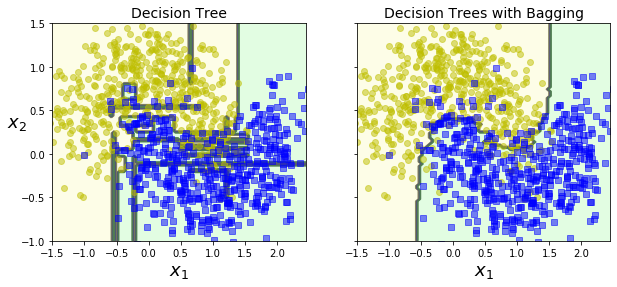

In [18]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

fix, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

#### **Out-of-Bag Evaluation**

In [6]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500, 
    max_samples=80, 
    bootstrap=True, 
    n_jobs=-1, 
    oob_score=True
)
bag_clf.fit(X_train, y_train)
print('Out-of-Bag score:', bag_clf.oob_score_)

from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
print('Accuracy socre:', accuracy_score(y_test, y_pred))

print('Out-of-Bag Decision Function:', bag_clf.oob_decision_function_[:])

Out-of-Bag score: 0.95
Accuracy socre: 1.0
Out-of-Bag Decision Function: [[0.         1.        ]
 [0.00540541 0.99459459]
 [1.         0.        ]
 [0.91326531 0.08673469]
 [0.06508876 0.93491124]
 [0.         1.        ]
 [0.05945946 0.94054054]
 [0.9950495  0.0049505 ]
 [0.86813187 0.13186813]
 [0.         1.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.45294118 0.54705882]
 [0.0960452  0.9039548 ]
 [0.16939891 0.83060109]
 [1.         0.        ]
 [0.08823529 0.91176471]
 [0.1        0.9       ]
 [0.13714286 0.86285714]
 [0.87978142 0.12021858]
 [0.95604396 0.04395604]
 [0.         1.        ]
 [0.05617978 0.94382022]
 [0.22099448 0.77900552]
 [0.48913043 0.51086957]
 [0.9516129  0.0483871 ]
 [0.77245509 0.22754491]
 [0.87830688 0.12169312]
 [1.         0.        ]
 [0.         1.        ]
 [0.92195122 0.07804878]
 [0.05660377 0.94339623]
 [1.         0.        ]
 [1.         0.        ]
 [0.70621469 0.29378531]
 [0.05699482 0.94300518]
 [0.08571429 0.91428571]
 [

### **Random Forests**

In [7]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)

# equal to bagging method as below
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
                           n_estimators = 500, max_samples = 1.0, bootstrap = True, n_jobs = -1)

#### **Extremely Randomized Trees (Extra-Trees)**

#### **Feature Importance**

In [8]:
# Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(iris["data"], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.08627603608936044
sepal width (cm) 0.02230614110986166
petal length (cm) 0.4376025458314549
petal width (cm) 0.45381527696932306


In [9]:
# MINST dataset example

# find the data location of the Scikit-Learn Data
from sklearn.datasets.base import get_data_home 
print (get_data_home())

from sklearn.datasets import fetch_mldata
#mnist = fetch_mldata('MNIST original')
#X, y = mnist['data'], mnist['target']

#rnd_clf.fit(X, y)
#feature_score = rnd_clf.feature_importances_


/Users/mengchen/scikit_learn_data


### **Boosting**

#### **AdoBoosting**

In [10]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1),  # max_depth --> Decision Stump is a Decision Tree with max_depth = 1: A tree composed of 
                             n_estimators = 200,                     # a single decision node plus two leaf nodes
                             algorithm = 'SAMME.R',                  # If AdaBoost ensemble is overfitting, try reducing the number of estimators or more strongly
                             learning_rate = 0.5)                    # regularizing the base estimator
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=None)

#### **Gradient Boosting**

In [10]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

# ALTERNATIVE Approach
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth =  2, n_estimators = 3, learning_rate = 1.0)
gbrt.fit(X, y)

NameError: name 'X_new' is not defined

<img src='fig7_9.png' width = 500>

#### <font color=orange>***5.2.1 Shrinkage***</font>: setting the learning_rate hyperparameter low to generate more trees for better predictions
<img src='fig7_10.png' width=500>

#### <font color=orange>***5.2.2 Optimal Number of Trees***</font>
* <font size=3>using <font color=brown>*staged_predict()*</font> method, measuring the validation error at each stage of training to find the optimal number of trees, and finally train another GBRT ensemble using the optimal number of trees</font>

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squred_error(y_val, y_pred)
          for y_pred in gbrt.predict(X_val)]
bst_n_estimators =  np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

NameError: name 'GradientBoostingRegressor' is not defined

* <font size=3>Early Stopping Implementation: setting <font color=green>*warm_start</font>=True*, keeping exsiting trees when the <font color=green>_fit()_</font> method is called</font>
* <font size=3 color=brown>Stochastic Gradient Boosting</font>
    * <font size=3>hyperparameter <font color=green>*subsample*</font>: specifies the fraction of training instances</font>
    * <font size=3>Trading a high bias for a lower variance</font>
    * <font size=3>Speeding up training</font>

In [ ]:
gbrt = GradientBoostingRegressor(max_depth = 2, warm_start = True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators =  n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5: # if when the validation error does not improve for five iterations in a row
            break # early stopping


### **Stacking**